# The Black-Scholes model 

In [1]:
# The model PDE: V_t + 0.5*sigma^2*S^2*V_SS + r*S*V_S - r*V = 0 (V_t-derivative of V  w.r.t to t, V_SS- 2nd order derivative)

#The domain of variables: 0=<t<=tmax,  0=<S<=Smax

#Initial condition: V(t=tmax,S) = max{S-K,0}

#Boundary condition: V(t,S=0) = 0,  
#                    V(t,S=Smax) = Smax - K * exp(-r * (tmax -t)) 


import tensorflow as tf
import numpy as np

#Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

#Values for the model parameters
r=0.05     #The interest rate 
sigma=0.25 #The standard deviation (of continuously compounded annual return of the stock)
K=40       #The strike price (used in the initial condition and in the change of variables for the analytical soultion)


#Boundary condition at the upper boundary (at S=Smax)
def fun_V_ub (S,t,K,r): 
    Smax=np.max(S)
    tmax=np.max(t)
    return Smax - K * np.exp(-r * (tmax -t))

#Initial condition 
def fun_V0(S,K):
    return np.fmax(S-K,0)

#PDE (solved upon the residuals points)
def fun_r(t,S,V,V_t,V_S,V_SS,r,sigma):
    return V_t+0.5*sigma**2*S**2*V_SS+r*S*V_S-r*V



# Set the range and the number of collocation points

In [2]:
#Number of residuals points 
N_r=5000   

#Number of points for the initial condition
N_0=100  

#Number of points for the boundary condition
N_b=100    

#Set the domain (range) of the variables
tmin=0
tmax=1
Smin=0
Smax=130

#Collect the variables at the lower bound
lb = tf.constant([tmin, Smin], dtype=DTYPE)

#Collect the variables at the upper bound
ub = tf.constant([tmax, Smax], dtype=DTYPE)

# Generate the collocation points

In [3]:
#Generate points for the boundary conditions (at S=0 and S=Smax)
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
S_lb = Smin*np.ones((N_b,1), dtype=DTYPE)
S_ub = Smax*np.ones((N_b,1), dtype=DTYPE)

#Collect t and S of the boundary conditions 
X_lb = tf.concat([t_b, S_lb], axis=1)  
X_ub = tf.concat([t_b, S_ub], axis=1)



#Generate points for the initial condition 
S_0=tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
t_0=tmax*np.ones((N_0,1),dtype=DTYPE)

#Collect t and S of the intial condition
X_0=tf.concat([t_0, S_0], axis=1)



#Generate points for the residuals
t_r = tf.random.uniform((N_r,1),tmin, tmax, dtype=DTYPE)
S_r = tf.random.uniform((N_r,1),Smin, Smax, dtype=DTYPE)

#Collect t and S of the residuals
X_r = tf.concat([t_r, S_r], axis=1)


# Visualize the collocation points

Text(0.5, 1.0, 'Positions of collocation points')

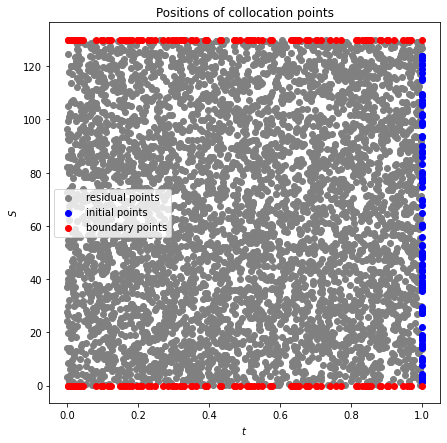

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
plt.scatter(t_r, S_r, c='gray', marker='o',label='residual points')
plt.scatter(t_0, S_0, c='b', marker='o',label='initial points')
plt.scatter(t_b, S_lb, c='r', marker='o',label='boundary points')
plt.scatter(t_b, S_ub, c='r', marker='o')
plt.xlabel('$t$')
plt.ylabel('$S$')
plt.legend(loc='center left')
plt.title('Positions of collocation points')

# Evaluate V on the bounadry and initial conditions

In [5]:
#Upper boundary 
V_ub = fun_V_ub(S_ub,t_b,K,r)

#Lower bounadry
V_lb=np.zeros((N_b,1),dtype=DTYPE)

#Initial condition
V_0=fun_V0(S_0,K)


# Collect boundary and inital data (for elegance, provides compact inputs for the "compute_loss" function)
X_data = [X_0, X_lb, X_ub]
V_data = [V_0, V_lb, V_ub]

# Neural network model

In [6]:
def init_model(num_hidden_layers=4,num_neurons_per_layer=50):
    model = tf.keras.Sequential()
    #input is 2d (t,S variables)
    model.add(tf.keras.Input(2))
    
    #Append hidden layers (activation is tanh)
    for i in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,activation=tf.keras.activations.get('tanh')
                                       ,kernel_initializer='glorot_normal')) #'glorot_normal' to initial values from
        # a normal distribution with a certain term for its std. It's mean is at zero.
    
    #Output layer
    model.add(tf.keras.layers.Dense(1))

    return model

# Evaluate V on the residuals

In [7]:
def get_r(model,X_r,r,sigma):
    # GradientTape is used for automatic differentiation 
    with tf.GradientTape(persistent=True) as tape:
        #within the Tape the variable and the function for the differentiation are defined
        t=X_r[:,0]
        S=X_r[:,1]

        tape.watch(t)  
        tape.watch(S)

        #Evaluate the model on the residuals (collocation) points
        V=model(tf.stack([t, S], axis=1))   # the model needs an input with shape: (N_r,2)

        # Compute V_S within the Tape (needed for V_SS)
        V_S = tape.gradient(V, S)


    #Compute V_t and V_SS (outside the Tape)
    V_t=tape.gradient(V,t)
    V_SS=tape.gradient((V_S),S)

    del tape

    return fun_r(t,S,V,V_t,V_S,V_SS,r,sigma)  


# Define the loss function

In [8]:
def compute_loss(model,X_r,X_data,V_data,r,sigma):     

    #Loss for the residuals 
    r=get_r(model,X_r,r,sigma)
    phi_r=tf.reduce_mean(tf.square(r)) #the mse term 

    #Loss for the intial condition
    phi_i=tf.reduce_mean(tf.square(model(X_data[0])-V_data[0]))

    #Loss for the boundary condition
    phi_lb=tf.reduce_mean(tf.square(model(X_data[1])-V_data[1]))
    phi_ub=tf.reduce_mean(tf.square(model(X_data[2])-V_data[2]))
    phi_b=phi_lb+phi_ub


    #sum of losses
    loss = phi_r+phi_i+phi_b

    return loss

# Differentiation of the loss function w.r.t model parameters

In [9]:
def get_grad(model,X_r,X_data,V_data,r,sigma):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)
        loss=compute_loss(model,X_r,X_data,V_data,r,sigma)

    g=tape.gradient(loss, model.trainable_variables) 
    
    del tape

    return loss,g


# Initialize the model

In [10]:
model=init_model()

#Set the learning rate
#learning rate is initialy 1e-2, decays to 1e-3 (after 1000 steps) and decays to 5e-4 (after 3000 steps)
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

#Set the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Train the model

In [11]:
def train_step(save=False):
    #calc current loss and its gradients
    loss, loss_grad=get_grad(model,X_r,X_data,V_data,r,sigma) 

    #apply gradient descent step
    optim.apply_gradients(zip(loss_grad, model.trainable_variables))
    
    
    #save the model (to call on last iteartion)
    if save:
        model.save('C:/Research/PINN/saved_models/2023_06_10/model3')

    return loss


#N is the num of epochs 
N=9000
hist=[]

for i in range(N):
    
    if i==N-1:   #to save the model on last iteration
        
        loss= train_step(1)
        
    else:

        loss=train_step()

    #add current loss to hist
    hist.append(loss)

    


INFO:tensorflow:Assets written to: C:/Research/PINN/saved_models/2023_06_10/model3\assets


# Plot the loss from training

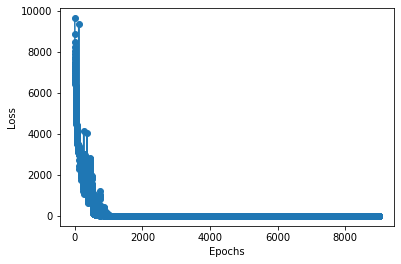

loss at the end of training: 3.1581742763519287


In [12]:
plt.plot(range(N),np.array(hist).flatten(),'-o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(f'loss at the end of training: {hist[-1]}')

# Evaluate the model by comparing it with the analytical solution (surface plot)

Text(0.5, 0, 'V analytical')

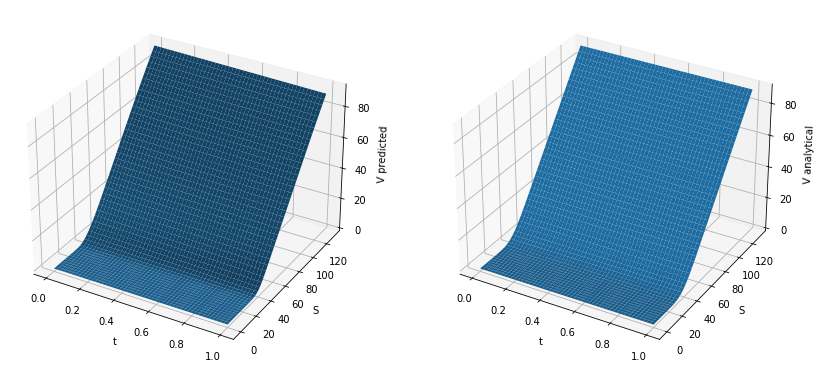

In [13]:
# Generate the model predictions

#Define a grid for t and S
epsilon=1e-5  # to prevent division by zero in the analytical solution
t=np.linspace(tmin,tmax-epsilon,50).reshape(-1,1)
S=np.linspace(Smin+epsilon,Smax,50).reshape(-1,1)
tmesh,Smesh=np.meshgrid(t, S)

#Model evaluation on the grid points
Xgrid = np.vstack([tmesh.flatten(),Smesh.flatten()]).T
saved_model=tf.keras.models.load_model('C:/Research/PINN/saved_models/2023_06_10/model3')    #use the saved model
V_pred = saved_model(tf.cast(Xgrid,DTYPE))
V_pred = V_pred.numpy().reshape(50,50)



#Generate the analytical solution
from scipy import special  #to use the erf fuction on an array (unlike math.erf)
def analytical_sol(t,S,tmax,K,sigma):
    T=tmax
    d_plus=(np.log(S/K)+(r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    d_minus=(np.log(S/K)+(r-0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
    Phi= lambda x:0.5*(1+special.erf(x/np.sqrt(2)))
    V_anal=S*Phi(d_plus)-K*np.exp(-r*(T-t))*Phi(d_minus)

    return V_anal



#Plot 3d surfaces of the predicted and the analytical solution 
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
surf1 = ax1.plot_surface(tmesh, Smesh, V_pred,label='predicted')  
surf2 = ax2.plot_surface(tmesh, Smesh, analytical_sol(t,S,tmax,K,sigma),label='analytical')
#ax1.view_init(120,30)
#ax2.view_init(120,30)
ax1.set_xlabel('t')
ax1.set_ylabel('S')
ax1.set_zlabel('V predicted')
ax2.set_xlabel('t')
ax2.set_ylabel('S')
ax2.set_zlabel('V analytical')

# Evaluate the model by comparing it with the analytical solution (2d plot with constant t lines)

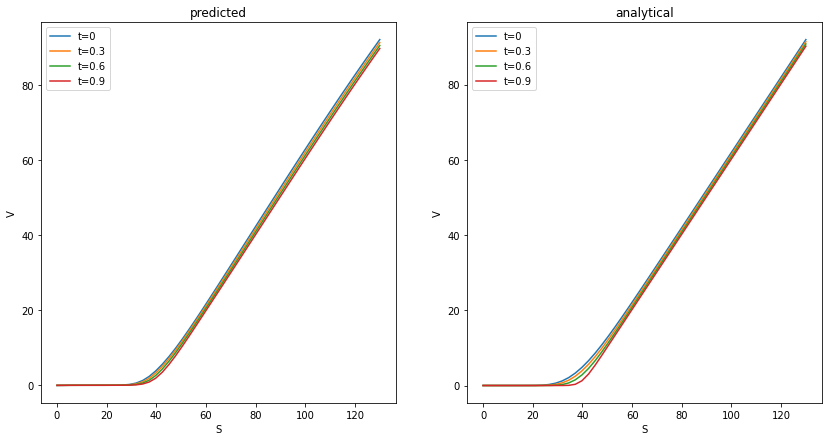

In [14]:
fig,axs=plt.subplots(1,2,figsize=(14,7))  #first subplot for model preication. Second for analytical sol
t_lines=[0,0.3,0.6,0.9]

for x in t_lines:
    axs[0].plot(S,saved_model(tf.stack([np.ones(50).reshape(-1,1)*x, S], axis=1)),label='t='+str(x))
    axs[1].plot(S,analytical_sol(np.ones(50).reshape(-1,1)*x,S,tmax,K,sigma),label='t='+str(x))
 
axs[0].set_xlabel('S')
axs[0].set_ylabel('V')
axs[1].set_xlabel('S')
axs[1].set_ylabel('V')
axs[0].set_title('predicted')
axs[1].set_title('analytical')
axs[0].legend()
axs[1].legend()